# *K-means* e *bisecting K-means* 

O objetivo deste projeto é realizar uma análise qualitative entre o K-means e o bisecting K-means. As bases de dados utilizadas serão a [Iris Dataset](https://archive.ics.uci.edu/ml/datasets/iris) e o [Wine Dataset](http://archive.ics.uci.edu/ml/datasets/Wine).

O pré-processamento e o estudo da redução de dimensionalidade foram efetuados no 


In [113]:
from sklearn import metrics
from time    import time
from math    import sqrt
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import random            as rd
    
# Argumentos e pré-definições do seaborn
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set(style="ticks")

filepath_iris = '../data/Iris-norm.csv'
filepath_wine = '../data/wine.csv'

iris_df = pd.read_csv(filepath_iris)

In [114]:
def plotter(doc, ks, label):
    X,Y = zip(*doc)
    kx,ky = zip(*ks)
    plt.scatter(x=X,y=Y, marker='o', c=label, cmap='gist_rainbow')
    plt.scatter(x=kx, y=ky, marker='x', color='black', s=150)

    
def plotter2(doc):
    X,Y = zip(*doc)
    plt.scatter(x=X,y=Y, marker='o', cmap='gist_rainbow')
    

In [115]:
def euclidianDistance(p1, p2):
    return sqrt( (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 )

In [116]:
MAX_ITER = 15
def goCondition(old_centroids, curr_centroids, itter):
    if itter >= MAX_ITER: return False    
    
    ctd = 0
    for old_centroid,curr_centroid in zip(old_centroids,curr_centroids):
        if abs(old_centroid[0]-curr_centroid[0]) <= 0.001 and\
           abs(old_centroid[1]-curr_centroid[1]) <= 0.001:
               ctd += 1
    if ctd == len(curr_centroids): return False
    
    return True

In [117]:
def defineNewCentroids(S, old_centroids, dist_func):
    color = {cen:i for i,cen in enumerate(old_centroids)}
    
    centroids = dict()
    labels = []
    
    for p in S:
        distances = [(dist_func(p, centroid), centroid) for centroid in old_centroids]
        closest_centroid = min(distances, key=lambda x: x[0])[1]
        
        label = color[closest_centroid]
        labels.append(label)
        
        if label not in centroids:
            centroids[label] = {"x":p[0], "y":p[1], "len":1}
        else:
            centroids[label]["x"] += p[0]
            centroids[label]["y"] += p[1]
            centroids[label]["len"] += 1
 
    new_centroids = [(c['x']/c['len'], c['y']/c['len']) for c in centroids.values()]

    return new_centroids,labels

In [118]:

def kmeans(S, k, dist_func):
    curr_centroids = [tuple(s) for s in rd.sample(S, k)]
    old_centroids  = [tuple(s) for s in rd.sample(S, k)]
    itter = 0
    
    while goCondition(old_centroids, curr_centroids, itter):
        old_centroids = curr_centroids       
        curr_centroids,predicted = defineNewCentroids(S, old_centroids, dist_func)
        itter += 1
        
    return predicted,old_centroids

Melhor valor para o K:   3
Obtendo uma acurácia de: 0.8856970310281228 (adjusted_rand_score)
Tempo: 0.7315771579742432


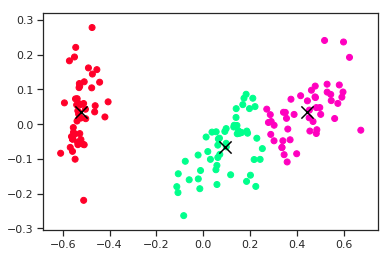

In [149]:
document = np.array(iris_df[iris_df.columns[1:-1]]).tolist()

maping = {key:count for count,key in enumerate(iris_df.species)}
y_true = [maping[i] for i in iris_df.species]

best_accuracy = -2
best_centr = []
best_k = -1
best_label = []
inicio = time()

for K in range(1, 40):
    y_pred, centroids = kmeans(document, K, euclidianDistance)
    
    accuracy = metrics.adjusted_rand_score(y_true, y_pred)
#     accuracy = metrics.v_measure_score(y_true, y_pred)

    if accuracy >= best_accuracy:
        best_accuracy = accuracy
        best_centr = centroids
        best_k = K
        best_label = y_pred

    final = time()
    
print(f"Melhor valor para o K:   {3}\nObtendo uma acurácia de: {best_accuracy} (adjusted_rand_score)\nTempo: {final-inicio}")
plotter(document, best_centr, best_label)

Time: 0.7561638355255127

Gráfico: K por Acurácia


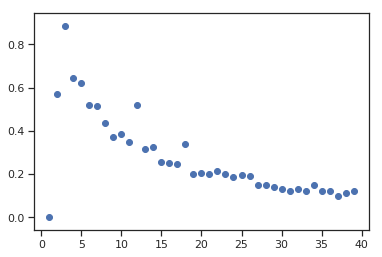

In [151]:
k_acc = []

inicio = time()
for K in range(1, 40):
    y_pred, _ = kmeans(document, K, euclidianDistance)

    accuracy = metrics.adjusted_rand_score(y_true, y_pred)
    
#     accuracy = metrics.v_measure_score(y_true, y_pred)
    k_acc.append([K, accuracy])

final = time()

plotter2(k_acc)

print(f"Time: {final-inicio}\n\nGráfico: K por Acurácia")